In [25]:
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F


# **Imagenet Resnet Implementation**
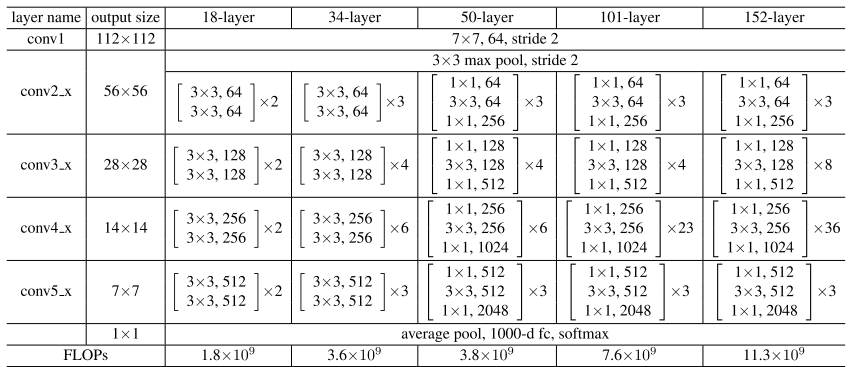

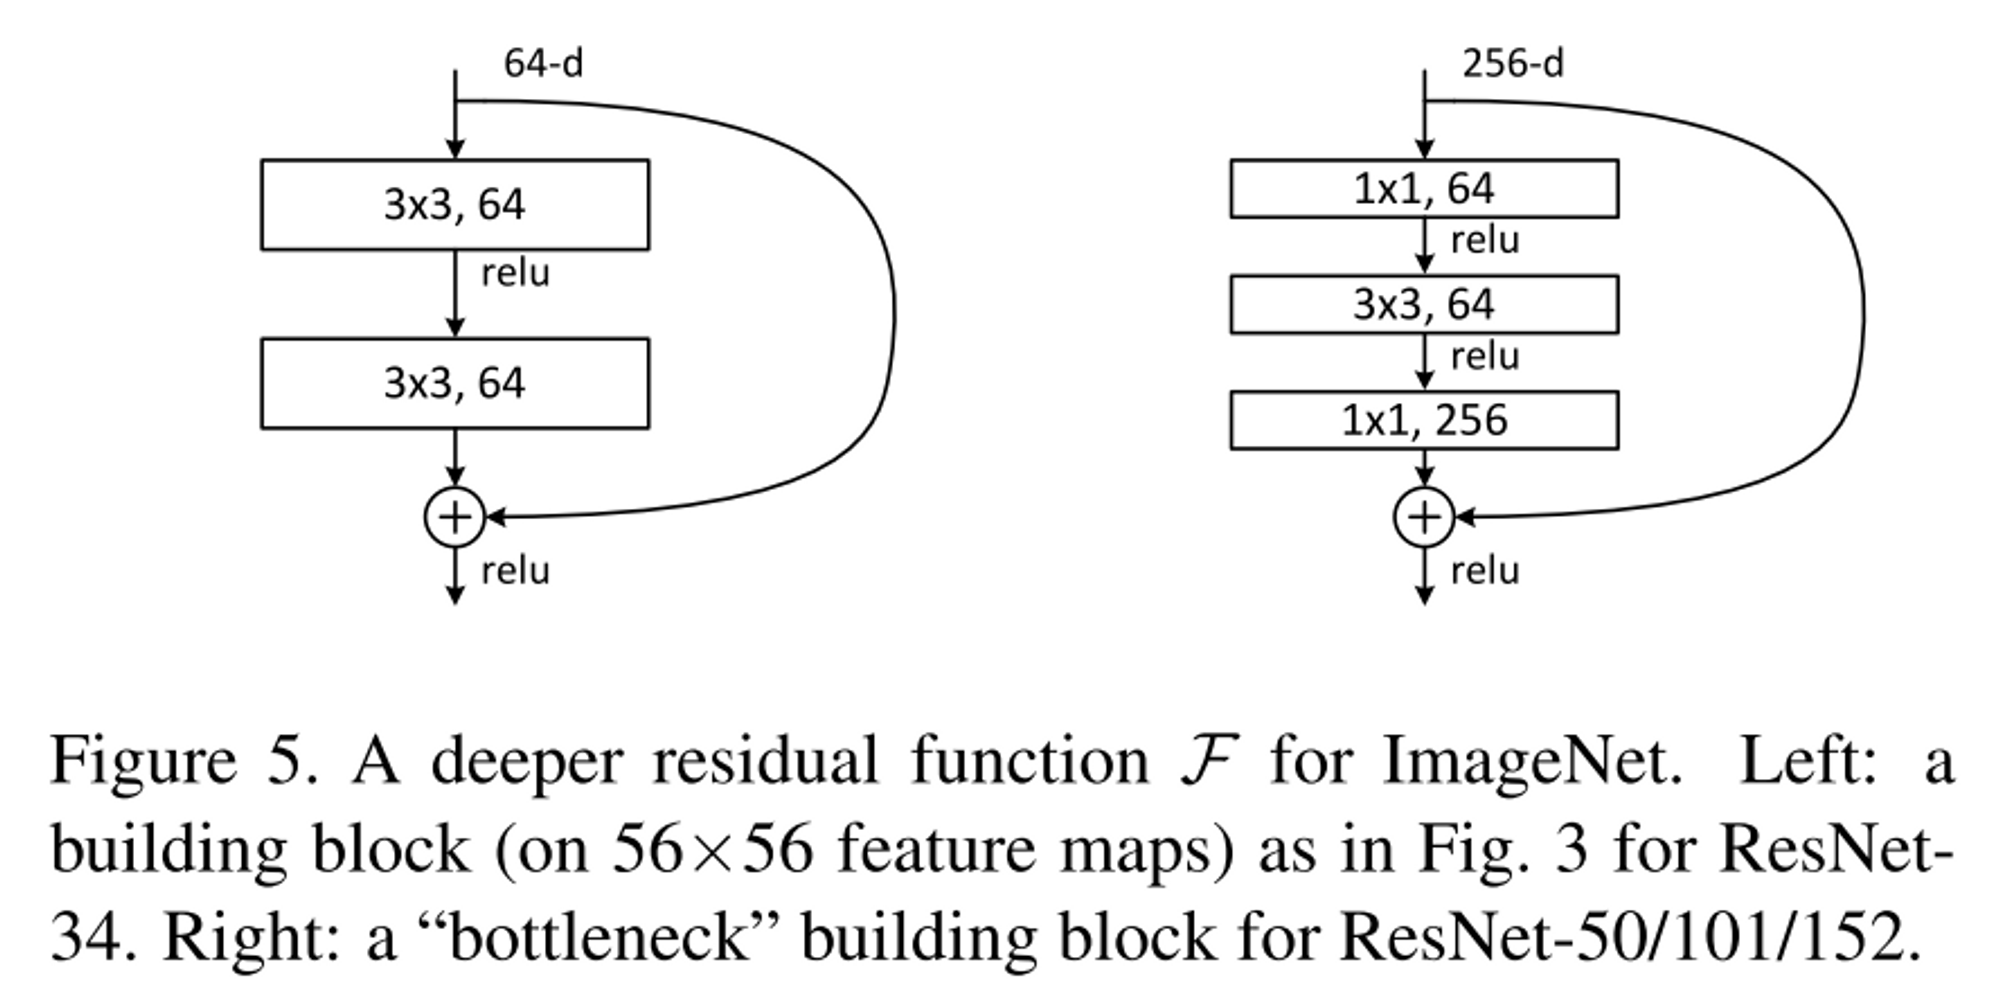

In [26]:

class BasicBlock(nn.Module):
    """
    3x3 conv 두 번 하는 convolution block
    padding은 same, bias는 false로.
    첫 번째 convolutional layer에서 __init__의 인수 stride만큼 stride를 갖고 convolution.
    in_planes : block input channel, planes : block 내부의 filter 개수
    """
    expansion = 1

    def __init__(self, in_planes, planes, normlayer, stride=1):
        super(BasicBlock, self).__init__()
        ####  design the layers
        # conv-norm-relu 순으로 layer 생성
        # 직접 적어도 되고, convnormrelu()같은 함수를 만들어도 되고 마음대로 해보기.
        # self.conv1 = nn.Conv2d(in_planes, planes, 3, stride, 'same', bias=False)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding='same' if stride == 1 else 1, bias=False)
        self.norm1 = normlayer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding='same', bias=False)
        self.norm2 = normlayer(planes)
        ####

        self.shortcut = nn.Sequential()
        # 실제 구현된 ResNet의 downsample영역 
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False,),
                normlayer(self.expansion * planes),
            )

    def forward(self, x):
        ##  design the forward function
        out = self.conv1(x)
        out = self.norm1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.norm2(out)
        ##
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    """
    1x1, 3x3, 1x1 conv 하는 convolution block
    padding은 크기가 똑같게, bias는 false로. 
    Note : stride가 1이 아닐 때 padding='same'으로 하면 안되고, 숫자로 크기 지정해야 함.
    첫 번째 convolutional layer에서 __init__의 인수 stride만큼 stride를 갖고 convolution.
    in_planes : block input channel, planes : block 내부의 filter 개수
    Note : 마지막 layer는 expansion(4) * plane 개수만큼의 channel 갖고 있음!
    """
   
    expansion = 4

    def __init__(self, in_planes, planes, normlayer, stride=1):
        super(Bottleneck, self).__init__()

        ####  design the layers
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, padding='same' if stride == 1 else 1, bias=False)
        self.norm1 = normlayer(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=1, stride=1, padding='same', bias=False)
        self.norm2 = normlayer(planes)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, stride=1, padding='same', bias=False)
        self.norm3 = normlayer(self.expansion * planes)
        self.relu = nn.ReLU(inplace=True)
        ####


        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False,),
                normlayer(self.expansion * planes),
            )

    def forward(self, x):
        ##  design the forward function
        out = self.conv1(x)
        out = self.norm1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.norm2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.norm3(out)
        ##
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, norm = 'bn', num_classes=1000):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.norm_layer = lambda planes:nn.GroupNorm(num_groups=2, num_channels = planes) if norm=='gn' else nn.BatchNorm2d(planes)

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.norm = self.norm_layer(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride= 1) # stride ?
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride= 2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride= 2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride= 2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)


    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, self.norm_layer, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.norm(self.conv1(x)))
        out = F.max_pool2d(out, kernel_size = 3, stride = 2, padding = 1)
        out = F.relu(self.norm(out))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 7)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2], 'bn')

def ResNet34():
   return ResNet(BasicBlock, [3, 4, 6, 3] , 'bn')


def ResNet50():
   return ResNet(Bottleneck, [3, 4, 6, 3] , 'bn')


def ResNet101():
   return ResNet(Bottleneck, [3, 4, 23, 3] , 'bn')


def ResNet152():
   return ResNet(Bottleneck, [3, 8, 36, 3] , 'bn')

res18 = ResNet18()

# **CIFAR10 resnet20 implementation**
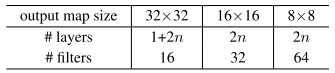

In [27]:
class CifarResNet(nn.Module):
    def __init__(self, block, num_blocks, norm = 'bn', num_classes=10):
        super(CifarResNet, self).__init__()
        self.in_planes = 16
        self.norm_layer = lambda planes:nn.GroupNorm(num_groups=2, num_channels = planes) if norm=='gn' else nn.BatchNorm2d(planes)

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.norm = self.norm_layer(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride= 1) # stride ?
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride= 2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride= 2)
        self.linear = nn.Linear(64 * block.expansion, num_classes)


    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, self.norm_layer, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.norm(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet20():
    return CifarResNet(BasicBlock, [3, 3, 3], 'bn')

def ResNet32():
   return CifarResNet(BasicBlock, [5, 5, 5] , 'bn')

def ResNet44():
   return CifarResNet(BasicBlock, [7, 7, 7] , 'bn')

def ResNet56():
   return CifarResNet(BasicBlock, [9, 9, 9] , 'bn')

def ResNet110():
   return CifarResNet(BasicBlock, [18, 18, 18] , 'bn')

def weight_init(submodule):
    if isinstance(submodule, torch.nn.Conv2d):
        torch.nn.init.kaiming_normal_(submodule.weight)
    elif isinstance(submodule, torch.nn.Linear):
        torch.nn.init.normal_(submodule.weight, std=0.01)

#**Data download, preprocessing**




In [28]:
# Imagenet data 등에서 많이 사용되는 normalization
trans_train = transforms.Compose(
                [
                    transforms.RandomHorizontalFlip(), # random하게 horizontal flip한 data로 학습 - data augmentation
                    transforms.ToTensor(),
                    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                ]
        )
trans_test = transforms.Compose(
            [transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),]
        ) # test 상황에서는 randomflip 필요 없음

dset_train = datasets.CIFAR10('/data', train=True, download=True, transform=trans_train)
# Train_dataset_num = int(len(dset_train) * 0.8) # integer
# Test_dataset_num = len(dset_train) - Train_dataset_num
Train_dataset_num = 45000
Test_dataset_num = 5000
Data_split = [Train_dataset_num, Test_dataset_num]
dset_train, dset_val = torch.utils.data.random_split(dset_train, Data_split)
dset_val.transform = trans_test
dset_test = datasets.CIFAR10('/data', train=False, download=True, transform=trans_test)

Files already downloaded and verified
Files already downloaded and verified


In [29]:
def train(net, dataloader):
    net.train()
    train_loss = 0
    correct = 0
    for images, labels in dataloader:
        images, labels = images.cuda(), labels.cuda() # GPU로 계산

        optimizer.zero_grad()

        log_probs = net(images)
        y_pred = torch.argmax(log_probs, dim = 1)

        correct += labels.data.eq(y_pred).sum().cpu().item()
        loss = loss_fn(log_probs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_accuracy = 100 * correct / len(dataloader.dataset)
    train_loss = train_loss / len(dataloader.dataset)
    scheduler.step()
    return train_loss, train_accuracy

In [30]:
def validation(net, dataloader):
    net.eval()
    val_correct = 0
    for images, labels in dataloader:
        images, labels = images.cuda(), labels.cuda()
        log_probs = net(images)
        y_pred = torch.argmax(log_probs, dim = 1)
        
        val_correct += labels.data.eq(y_pred).sum().cpu().item()

    val_accuracy = 100 * val_correct / len(dataloader.dataset)

    return val_accuracy

In [31]:
def print_parameters(model_ft):
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name, param.shape)
    num_of_params = []
    for i in params_to_update:
        num_of_params.append(list(i.view(-1).shape).pop())
    print(f'num of params: {sum(num_of_params)}')
    # return params_to_update, num_of_params
net = ResNet20()
print_parameters(net)

	 conv1.weight torch.Size([16, 3, 3, 3])
	 norm.weight torch.Size([16])
	 norm.bias torch.Size([16])
	 layer1.0.conv1.weight torch.Size([16, 16, 3, 3])
	 layer1.0.norm1.weight torch.Size([16])
	 layer1.0.norm1.bias torch.Size([16])
	 layer1.0.conv2.weight torch.Size([16, 16, 3, 3])
	 layer1.0.norm2.weight torch.Size([16])
	 layer1.0.norm2.bias torch.Size([16])
	 layer1.1.conv1.weight torch.Size([16, 16, 3, 3])
	 layer1.1.norm1.weight torch.Size([16])
	 layer1.1.norm1.bias torch.Size([16])
	 layer1.1.conv2.weight torch.Size([16, 16, 3, 3])
	 layer1.1.norm2.weight torch.Size([16])
	 layer1.1.norm2.bias torch.Size([16])
	 layer1.2.conv1.weight torch.Size([16, 16, 3, 3])
	 layer1.2.norm1.weight torch.Size([16])
	 layer1.2.norm1.bias torch.Size([16])
	 layer1.2.conv2.weight torch.Size([16, 16, 3, 3])
	 layer1.2.norm2.weight torch.Size([16])
	 layer1.2.norm2.bias torch.Size([16])
	 layer2.0.conv1.weight torch.Size([32, 16, 3, 3])
	 layer2.0.norm1.weight torch.Size([32])
	 layer2.0.norm1.bias

 10%|█         | 2/20 [00:30<04:38, 15.47s/it]

train loss =  0.007811695982350243 , train acc =  64.33555555555556 , val_acc =  54.02


 20%|██        | 4/20 [01:00<04:04, 15.25s/it]

train loss =  0.005337949985265732 , train acc =  76.12 , val_acc =  70.64


 30%|███       | 6/20 [01:30<03:32, 15.17s/it]

train loss =  0.004297054424550798 , train acc =  80.78444444444445 , val_acc =  77.7


 40%|████      | 8/20 [02:01<03:01, 15.16s/it]

train loss =  0.003697069552871916 , train acc =  83.72888888888889 , val_acc =  78.32


 50%|█████     | 10/20 [02:31<02:31, 15.15s/it]

train loss =  0.0032419948736826577 , train acc =  85.56444444444445 , val_acc =  79.22


 60%|██████    | 12/20 [03:02<02:04, 15.51s/it]

train loss =  0.0029025385823514727 , train acc =  87.09777777777778 , val_acc =  82.0


 70%|███████   | 14/20 [03:33<01:32, 15.38s/it]

train loss =  0.0027037189652522405 , train acc =  87.88666666666667 , val_acc =  78.12


 80%|████████  | 16/20 [04:03<01:01, 15.31s/it]

train loss =  0.0024936975409587223 , train acc =  88.88888888888889 , val_acc =  81.36


 90%|█████████ | 18/20 [04:33<00:30, 15.30s/it]

train loss =  0.002316716768344243 , train acc =  89.61111111111111 , val_acc =  83.7


100%|██████████| 20/20 [05:04<00:00, 15.20s/it]

train loss =  0.0021579896872242293 , train acc =  90.18 , val_acc =  82.72


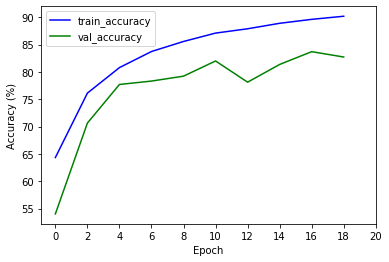

test accuracy =  81.67


In [32]:
net = ResNet20()
net = net.cuda()
net.apply(weight_init)

batch_size = 128
train_epoch = 20
lr = 0.1
weight_decay = 0.0001
momentum = 0.9


train_dl = DataLoader(dset_train, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(dset_val, batch_size=batch_size, shuffle=False)
test_dl = DataLoader(dset_test, batch_size=batch_size, shuffle=False)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay = weight_decay, momentum = momentum)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = [32000,48000], gamma=0.1) # lr = lr*gamma when epoch is in milestone

plot_step = 2 # plot_step epoch마다 accuracy 출력
train_acc_list = []
val_acc_list = []

for i in tqdm(range(1, train_epoch+1)):
    train_loss , train_accuracy = train(net, train_dl)
    scheduler.step()
    if i%plot_step==0:
        train_acc_list.append(train_accuracy)
        val_accuracy = validation(net, val_dl)
        val_acc_list.append(val_accuracy)


        print('train loss = ', train_loss, ', train acc = ', train_accuracy, ', val_acc = ', val_accuracy)


plt.plot(np.arange(train_epoch//plot_step), train_acc_list, 'b', label = 'train_accuracy')
plt.plot(np.arange(train_epoch//plot_step), val_acc_list, 'g', label = 'val_accuracy')
plt.xticks(ticks=list(range(int(train_epoch/2) + 1)), labels=list(range(0, 2 * (int(train_epoch/2) + 1), 2)))
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()


test_accuracy = validation(net, test_dl)
print('test accuracy = ', test_accuracy)

# *Note*
Block에서 shortcut을 없애면 resnet 논문의 plain.

plain과 비교하려면 shortcut connection을 없앤 block을 정의하고,

그를 이용하여 plain class를 정의한 후, plain과 비교.

### (Optional)

https://arxiv.org/abs/1605.07146

Wide Resnet

Resnet block에서 plane 개수를 k배 => 더 shallow하지만 fat(filter channel 개수가 많음)한 네트워크로 resnet보다 좋은 성능

위 ResNet class에서 width k 인자를 추가하여 구현 가능